In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib import cm

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v7_IRLS'

# Panel a

In [4]:
res_corsi = loadmat(f'../../../all_corsi_log_{version}.mat')['all_corsi'][0]
_jid = res_corsi[0].flat[0]
age_corsi = _jid[3]
gender_corsi = _jid[4]
print(age_corsi.shape)

res_2back = loadmat(f'../../../all_2back_log_{version}.mat')['all_2back'][0]
_jid = res_2back[0].flat[0]
age_2back = _jid[3]
gender_2back = _jid[4]
print(age_2back.shape)

res_rtime = loadmat(f'../../../all_rtime_log_{version}.mat')['all_r_time']
_jid = res_rtime[0][0].flat[0]
age_sRT = _jid[3]
print(age_sRT.shape)
_jid = res_rtime[1][0].flat[0]
age_cRT = _jid[3]
gender_cRT = _jid[4]
print(age_cRT.shape)

res_switch = loadmat(f'../../../all_switch_log_{version}.mat')['all_switch']
_jid = res_switch[0][0].flat[0]
age_global = _jid[3]
gender_global = _jid[4]
print(age_global.shape)
_jid = res_switch[1][0].flat[0]
age_local = _jid[3]
print(age_local.shape)

(175, 1)
(128, 1)
(179, 1)
(180, 1)
(117, 1)
(117, 1)


,min,N,type,25th,75th,females,50th,max
0,21,180,Reaction time,46.75,68.0,120,60.5,85
1,21,128,2-back,47.00,68.0,89,60.5,85
2,21,175,Corsi,48.50,68.5,117,61.0,85
3,21,117,Task switch,46.00,67.0,85,60.0,85


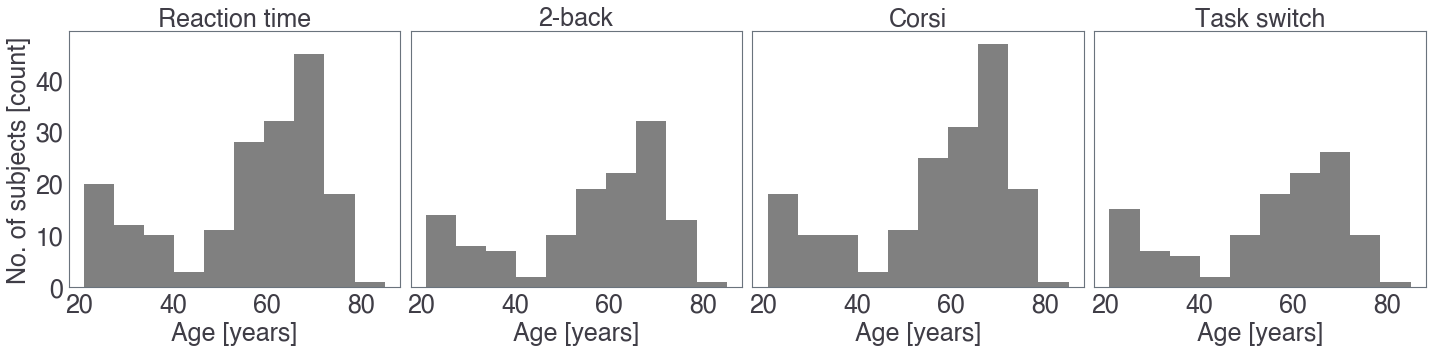

In [36]:
df_fig3pana = pd.DataFrame(columns={'type', 'N', 'females', 'min', 'max', '25th', '50th', '75th'})
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
for i, (_title, values, genders) in enumerate(zip(['Reaction time', '2-back', 'Corsi', 'Task switch'], 
                                         [age_cRT, age_2back, age_corsi, age_global], 
                                         [gender_cRT, gender_2back, gender_corsi, gender_global])):  
    
    ax[i].hist(values, color='grey')
    ax[i].set_title(_title)
    ax[i].set_xlabel('Age [years]')
    ax[i].grid(False)
#     ax[i].text(20, 36, f"N = {len(values)}", fontsize=25)
    df_fig3pana = df_fig3pana.append({'type': _title, 'N': len(values), 'females': np.sum(genders == 2),
                                      'min': np.min(values), 'max': np.max(values), 
                                      '25th': np.percentile(values, 25), 
                                      '50th': np.percentile(values, 50),
                                      '75th': np.percentile(values, 75)}, ignore_index=True)
ax[0].set_ylabel("No. of subjects [count]");
plt.tight_layout()
plt.savefig('figure_2_panel_a.pdf')
df_fig3pana.to_csv('figure_2_panel_a.csv', index=False)
df_fig3pana

# Panel b

In [7]:
res_sRT = res_rtime[0]
res_cRT = res_rtime[1]
res_global = res_switch[0]
res_local = res_switch[1]

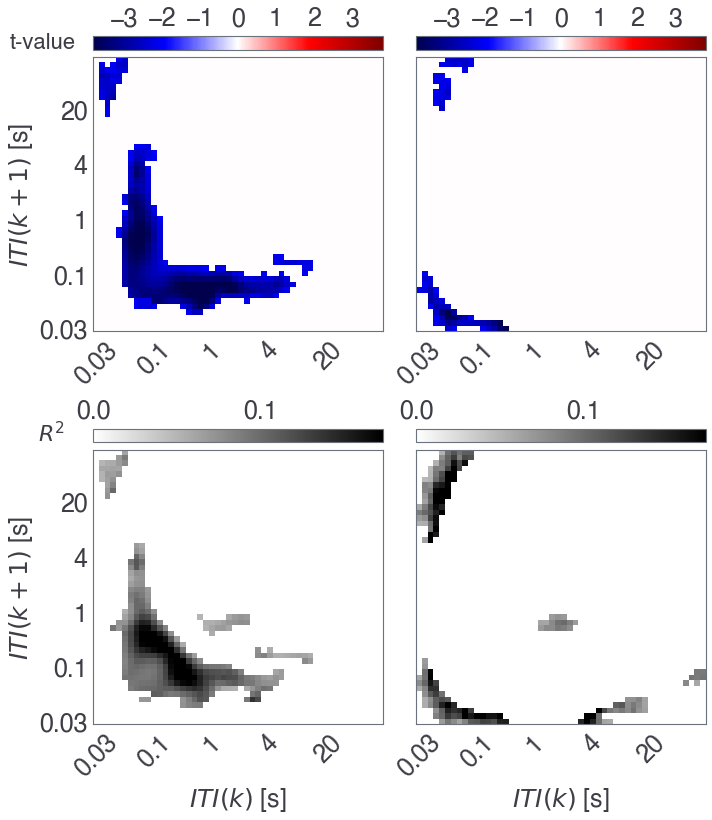

In [38]:
TITLES = ['cRT' , 'switchGlobal', ] 
VALUES = [res_cRT, res_global]
fig, ax = plt.subplots(2, 2, figsize=(10, 11.5), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 1

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(2):
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]
              
    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))
    
tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social']):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none')
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-15, 51, 't-value', size=22)    
ax[1][0].text(-10, 51, r'$R^2$', size=22)    

plt.tight_layout()
plt.savefig(f'figure_2_panel_b_{TITLES[IDX]}.pdf', transparent=True)

# Panel c

<ipython-input-40-e64d54c85889>:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,beta,f-value,N,R2,JID,p-value
0,-1.000023,11.461647,117,0.178986,Full,0.000029
1,-16.330645,10.428995,114,0.181072,Social,0.000071


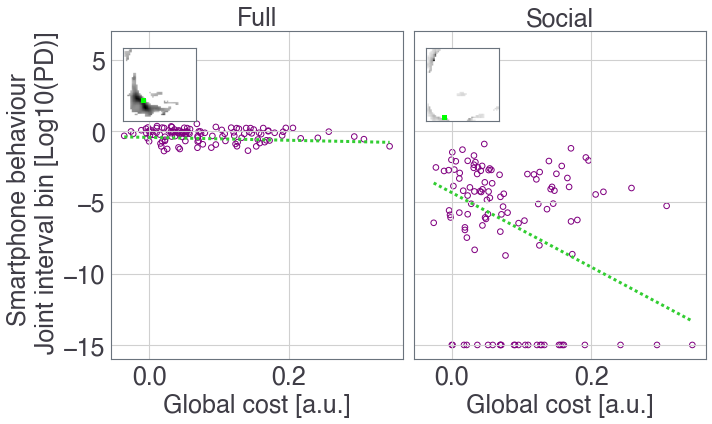

In [40]:
df_fig2panc = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})

TITLES = ['cRT', 'switchGlobal'] 
VALUES = [res_cRT, res_global]
XLABELS = ['Reaction time [ms]', 'Global cost [a.u.]']

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 1

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)

for i, _title in enumerate(['Full', 'Social']):
    
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    A = data_it[3].squeeze()
    B = data_it[4].squeeze()
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        p_uni[j] = continuous[1]
    
    r2_full[r2_full > 1] = 0
    r2_full_new = (r2_full.reshape(50, 50).T * np.sign(mask_full)).T.reshape(-1)

    idx = np.argsort(r2_full)[-20]
    _y = A[:, idx]
    _x = B[:, 0]
    _min = np.argmin(_x)
    _max = np.argmax(_x)
    MM = B @ betas.T
    mm = MM[:, idx]
    
    ax[i].scatter(_x, _y, facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[i].plot([_x[_min], _x[_max]], [mm[_min], mm[_max]], 'limegreen', dashes=[1, 1], linewidth=3, label="Linear Fit")
    
    ax[i].set_ylim([-16, 7])
    ax[i].set_title(_title)
    ax[i].set_xlabel(XLABELS[IDX])

    df_fig2panc = df_fig2panc.append({'JID': _title, 'N': len(_x),  'R2': r2_full[idx], 'p-value': p_full[idx], 
                                      'f-value': f_full[idx], 'beta':betas[idx, 0]}, ignore_index=True)
    
    inset_ax = inset_axes(ax[i], height="25%", width="25%", loc='upper left')
    
    square_r2_full = r2_full.reshape(50, 50).T
    
    inset_ax.imshow(np.sign(mask_full) * square_r2_full, cmap='binary')
    inset_ax.xaxis.set_visible(False)
    inset_ax.yaxis.set_visible(False)
    inset_ax.grid(False)
    inset_ax.invert_yaxis()
    x1 = idx % 50
    y1 = idx // 50;
    rect1 = matplotlib.patches.Rectangle((y1, x1), 2, 2, linewidth=2, edgecolor='lime', facecolor='lime')
    inset_ax.add_patch(rect1)
    
ax[0].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]");
plt.tight_layout()
plt.savefig(f"figure_2_panel_c_{TITLES[IDX]}.pdf", transparent=True)
df_fig2panc.to_csv(f'figure_2_panel_c_{TITLES[IDX]}.csv', index=False)
df_fig2panc

# Panel d

<ipython-input-42-bbde0da01892>:36: UserWarning: No contour levels were found within the data range.
  im = ax[i].contour(Z * np.sign(mask_full) * np.sign(masks_uni[0]), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)


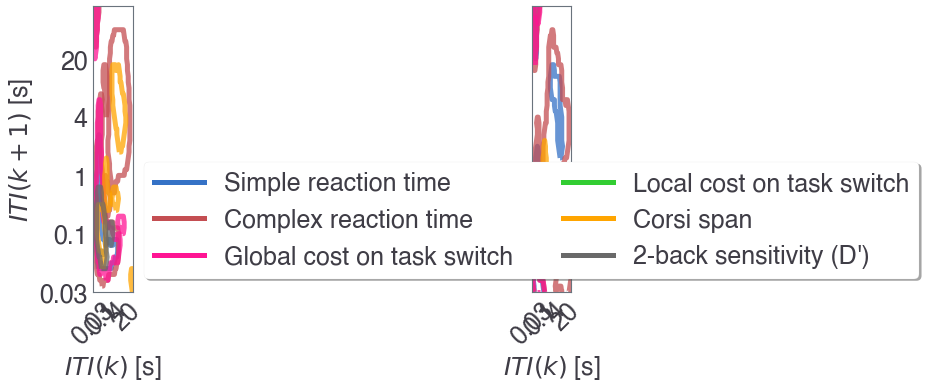

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5.5), sharey=True, sharex=True)
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
CMAPS = ['b', 'r', 'deeppink', 'limegreen', 'orange', 'dimgrey']
TITLES = ['Simple reaction time', 'Complex reaction time', 'Global cost on task switch', 'Local cost on task switch', 'Corsi span', "2-back sensitivity (D')"] 
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

x = np.arange(1.5, 5, (5 - 1.5) / 50)
X, Y = np.meshgrid(x, x)
Bs = []
for i, _title in enumerate(['Full',  'Social']):
    for IDX, V in enumerate(VALUES):
        data_it = V[ORDER[i]].flat[0][1].flat[0]
        masks = [m[0].reshape(50, 50).T for m in data_it[0]]
        masks_uni = masks[:-1]
        mask_full = masks[-1]
        mdl = data_it[2]
        Bs.append(data_it[4])
        f_full = np.zeros(2500)
        f_uni = np.zeros((2500, 2))

        # mdl is 2500 long
        for j, obj in enumerate(mdl):
            pixel = obj.flat[0][0][0]
            f_uni[j] = continuous[0]
            if "OLS" in version:
                f_full[j] = pixel[4][0][0]
            else:
                f_full[j] = pixel[1][0][0]

        square_f = f_uni[:, 0].reshape(50, 50).T
        Z = square_f
        norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
        
#         im = ax[i].contour(Z * np.sign(mask_full), [2, 8, 16], colors=CMAPS[IDX], alpha=1, norm=norm, linestyles=['dotted', '--', '-'])
        im = ax[i].contour(Z * np.sign(mask_full) * np.sign(masks_uni[0]), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)
        ax[i].plot([0], [0], color=CMAPS[IDX], label=TITLES[IDX], linewidth=5)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlabel(r'$ITI(k)$ [s]')
        ax[i].grid(False)
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[1].legend(loc='upper center', shadow=True, fancybox=True, ncol=2, bbox_to_anchor=[0, 0.5])
plt.tight_layout()
plt.savefig('figure_2_panel_d_legend.pdf')

# Supplementary b.i.

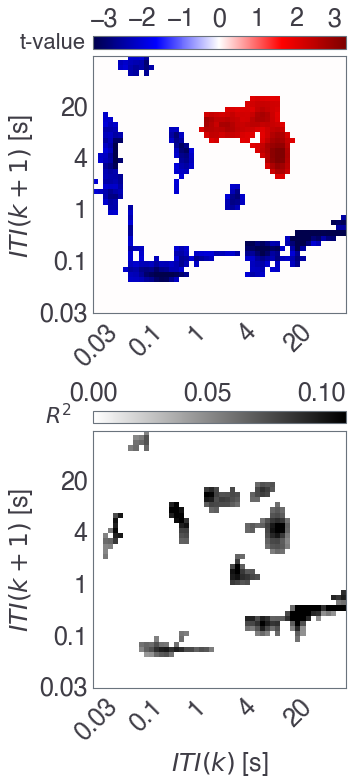

In [44]:
TITLES = ['cRT' , 'switchGlobal', ] 
VALUES = [res_cRT, res_global]
fig, ax = plt.subplots(2, 1, figsize=(5, 11), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 1

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(2):
    data_it = VALUES[IDX][3].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]
              
    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))
    
tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Transition']):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][3].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0].invert_yaxis()
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels)
    ax[0].xaxis.set_tick_params(rotation=45)
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0].grid(False)
    divider = make_axes_locatable(ax[0])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
    im = ax[1].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none')
    ax[1].invert_yaxis()
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)
    ax[1].xaxis.set_tick_params(rotation=45)
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    ax[1].set_xlabel(r'$ITI(k)$ [s]')
    ax[1].grid(False)
    divider = make_axes_locatable(ax[1])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-15, 51, 't-value', size=22)    
ax[1].text(-10, 51, r'$R^2$', size=22)    

plt.tight_layout()
plt.savefig(f'figure_2_supplementary_b_i_{TITLES[IDX]}.pdf', transparent=True)

# Supplementary b.ii.

<ipython-input-35-e40701b70346>:118: RuntimeWarning: invalid value encountered in multiply
  im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary',


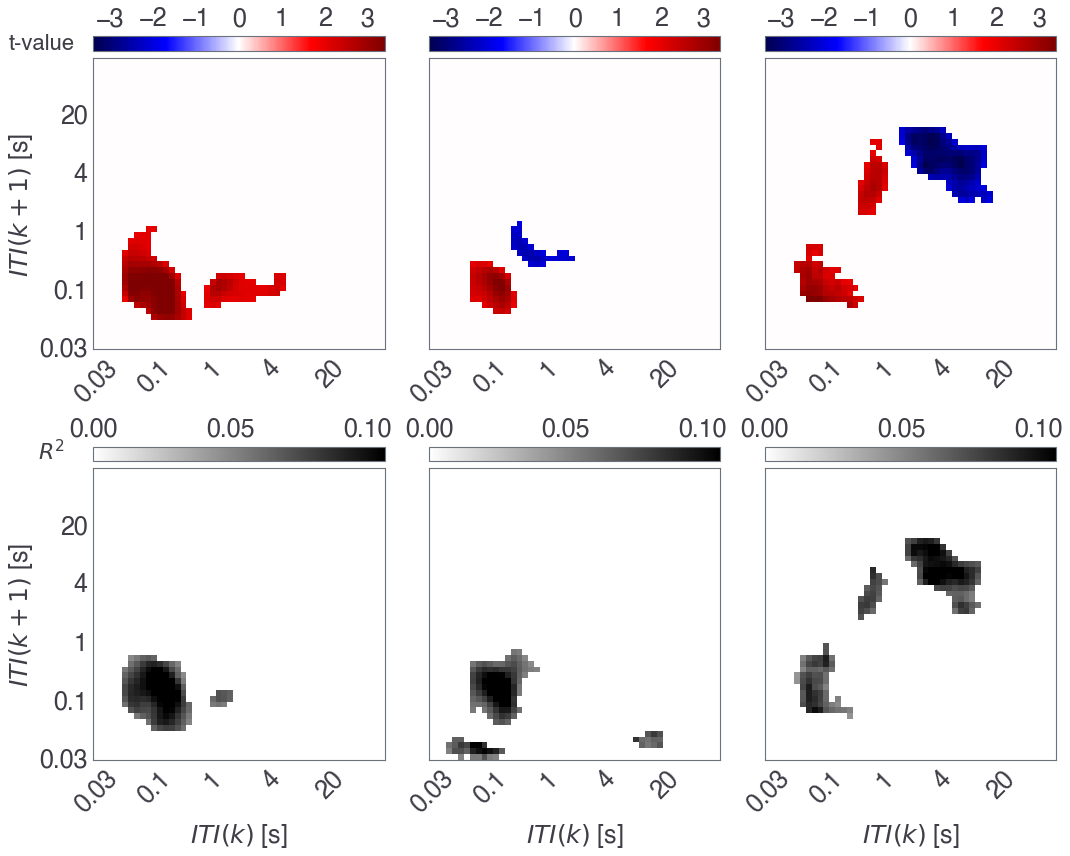

In [35]:
TITLES = ['sRT', 'switchLocal', 'corsi', '2back'] 
VALUES = [res_sRT, res_local, res_corsi, res_2back]
fig, ax = plt.subplots(2, 3, figsize=(15, 12), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 3

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(3):
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]
              
    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))
    
tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition']):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        if "OLS" in version:
            r2_full[j] = pixel[3][0][0]
            f_full[j] = pixel[4][0][0]
            p_full[j] = pixel[6][0][0]
            betas[j] = pixel[1].squeeze()
            p_uni[j] = continuous[2]
        else:
            r2_full[j] = pixel[0][0][0]
            f_full[j] = pixel[1][0][0]
            p_full[j] = pixel[2][0][0]
            betas[j] = pixel[3].squeeze()
            p_uni[j] = continuous[1]

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none')
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-15, 51, 't-value', size=22)    
ax[1][0].text(-10, 51, r'$R^2$', size=22)    

plt.tight_layout()
plt.savefig(f'figure_2_supplementary_b_ii_{TITLES[IDX]}.pdf', transparent=True)

# Supplementary x.i.